In [1]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [2]:
## Custom imports
from matplotlib.cm import jet
from scipy.stats import binom, poisson, chi2, norm, uniform
from scipy.optimize import curve_fit
from math import ceil, pi
from numpy import exp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import makeMappingArray, ListedColormap
import pandas as pd
from tqdm import trange

In [3]:
## Adding a button to hide the Python source code
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10791: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.renebreton.org">Prof. Rene Breton</a> - Twitter <a href="https://twitter.com/BretonRene">@BretonRene</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Dr. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

# Chapter 12

## Syllabus

1. Probabilities and interpretations
2. Probability distributions
3. Parameter estimation
4. Maximum likelihood + extended maximum likelihood
5. Least square, chi2, correlations
6. Monte Carlo basics
7. Probability 
8. Hypothesis testing
9. Confidence level
10. Goodness of fit tests
11. Limit setting
12. **Introduction to multivariate analysis techniques**

## Topics

**[12 Multi-variate analyses](#12-Multi-variate-analyses)**

**[12.1 Introduction](#12.1-Introduction)**

**[12.2 Receiver-Operating Characteristic curve](#12.2-Receiver-Operating-Characteristic-curve)**

**[12.3 Cross-validation](#12.3-Cross-validation)**

**[12.4 Multi-variate classification techniques](#12.4-Multi-variate-classification-techniques)**

## 12 Multi-variate analyses


### 12.1 Introduction

This part of the lecture follows chapter 5 of Behnke, written by Helge Voss. Some of the code examples are taken from <a href="http://www.scipy-lectures.org">www.scipy-lectures.org</a>, which is a rich resource of examples with decent explanation in all aspects of scientific python from simple maths to machine learning.

The topic can easily fill a whole lecture course; hence, we have to be rather selective and to some extent superficial here.

There are two topics that are covered by multi-variate analyses: classification and regression. We will concentrate here on the former.

Classification covers the distinction of two or more classes of items in those of interest and those that are not.

The term multi-variate refers to the fact that we consider the information from several variables of interest, often called _features_ in this context, rather than just analysing a single observable. The multi-variate analysis then transforms this set of variables into a single output variable. Let us call the input set ${\bf x}=\{x_1,\ldots,x_D\}$, also referred to as the _feature vector_, and correspondingly the output $y({\bf x})$.

You can think back to the Martian rock classification as an example. There, we discussed the classification based on a single oxide concentration. Within the context of this chapter, we can extend this to the joint analysis of all measured concentrations.

#### 12.1.1 Linking classification to previous topics

Classification can be interpreted as a hypothesis test. In this case the null hypothesis, $H_0$, is that the item to classify is not of interest. Depending on the value of the test statistic $y({\bf x})$ we then reject this hypothesis or not.

The performance of a multi-variate classifier is assessed by the rate of Type I and II errors, i.e. how often items are wrongly declared to be of interest (Type I error) or how often items are wrongly found to be not of interest (Type II error). As before the trade-off between these two rates depends on the application in question.

Let us call the items of interest signal ($S$) and those not of interest background ($B$). Their distinction is then linked to the test statistic exceeding a critical value in which case we accept the outcome as signal:

$$y({\bf x})>c.$$

We can consequently define a critical region $C$ in parameter space where this equation is satisfied. With this, the rate of Type I errors or the significance is

$$\alpha=\int_C p({\bf X}|H_0)d{\bf x} = \int_C p({\bf X}|B)d{\bf x} = \int_{y({\bf x})>c}p({\bf X}|B)d{\bf x}.$$

This also defines the rate of Type II errors as

$$\beta=\int_{y({\bf x})<c}p({\bf X}|S)d{\bf x}.$$

In this context, we can also identify $1-\beta$, which is usually called power, as the signal efficiency, and $1-\alpha$ as the background rejection.

Rather than considering the complicated observable space in which we have a hyper-surface called decision boundary, defined by $y({\bf x})=c$, we can also consider the classifier output, which leads to

$$\int_{c}^\infty p(y|B)dy=\alpha,$$

and

$$\int_{-\infty}^{c} p(y|S)dy = \beta.$$

A graphical example is given below in 12.2.

Following Bayes, we can calculate the rate of signal decisions if we now the overall fraction of signal ($f_S$) and background ($f_B$) items as

$$P_S(y)\equiv P(S|y)=\frac{p(y|S)f_S}{p(y|S)f_S+p(y|B)(1-f_S)}.$$

#### 12.1.2 Machine Learning

The term _machine learning_ simply describes the automatic determination of the possible decision boundaries of a classifier, i.e. it determines the function $y({\bf x})$ that transforms the feature vector into a single output quantity. 

The term _supervised learning_ refers to the usage of a training dataset for which the true classification is known.
_Unsupervised learning_ performs classification without being instructed which characteristics to pick out and is typically used in cluster finding or self-organising maps.

A classical example is the Iris, which a genus of 260-300 species of flowering plants. Some of the Iris varieties look very similar (see below) but have subtle differences when it come to the length and width of their petals for instance.

<img src="images/iris.png" width=80%>

#### 12.1.3 Bias-variance trade-off

When training a multi-variate classifier the configuration of the algorithm determines the number of degrees of freedom and through these the ability of the classifier to pick out small-scale features of the training dataset.

A classifier with few degrees of freedom will lead to very similar results when trained on statistically independent datasets that all are drawn from the same underlying distribution. This is called small _variance_. At the same time, the result will lead to a deviation from the individual dataset as it would not pick out the most fine-grained features; this is called the _bias_ of the classifier.

Conversely, when the classifier is given many degrees of freedom, it will have a smaller bias at the expense of a larger variance.  The balancing of these different criteria is called bias-variance trade-off.

At the point when it starts to pick out statistical fluctuations of the training set it is called _overtrained_.
One way to avoid this is to exploit several datasets that all represent the same underlying distributions. They can for example all be randomly drawn subsets of one bigger sample. The first is called _training dataset_ and is used for the initial round of machine learning. A second set, the _validation dataset_ is used to evaluate the classifier. The training is performed with increasing complexity (i.e. number of degrees of freedom of the algorithm), which should lead to improving signal-background separation. So long as this separation is confirmed by the validation sample all is good. Once the validation sample no longer shows the same improvement of the training sample, the point of overtraining has been reached. Finally, the classifier is applied to a third sample, the test sample.

<img src="images/Overfitting.png" width=40%>
(Source: [Chabacano](https://commons.wikimedia.org/wiki/User:Chabacano), [Overfitting](https://commons.wikimedia.org/wiki/File:Overfitting.svg), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/legalcode))

### 12.2 Receiver-Operator Characteristic curve

As discussed before, the optimal working point of Type I/II errors or signal efficiency and background rejection depends on the specific problem being analysed. It is instructive to illustrate the different options. The Receiver-Operating Characteristic (ROC) curve shows background rejection as a function of signal efficiency and is constructed by evaluating all possible critical values $c$. 

The ROC curve must always start at $(0,1)$, which corresponds to zero signal efficiency and $100\%$ background rejection, i.e. everything is rejected. The opposite end of the curve is at $(1,0)$, where everything is accepted, i.e. $100\%$ signal efficiency but zero background rejection.

The example below uses two hypothetical signal and background classifier output distributions and builds a ROC curve for these, including highlighting some example points.

The accepted region lies to the right of the threshold value.
The orange curve represents the signal distribution and the blue curve shows the background distribution.
The right-hand graph shows background rejection against signal efficiency, i.e. the ROC curve.

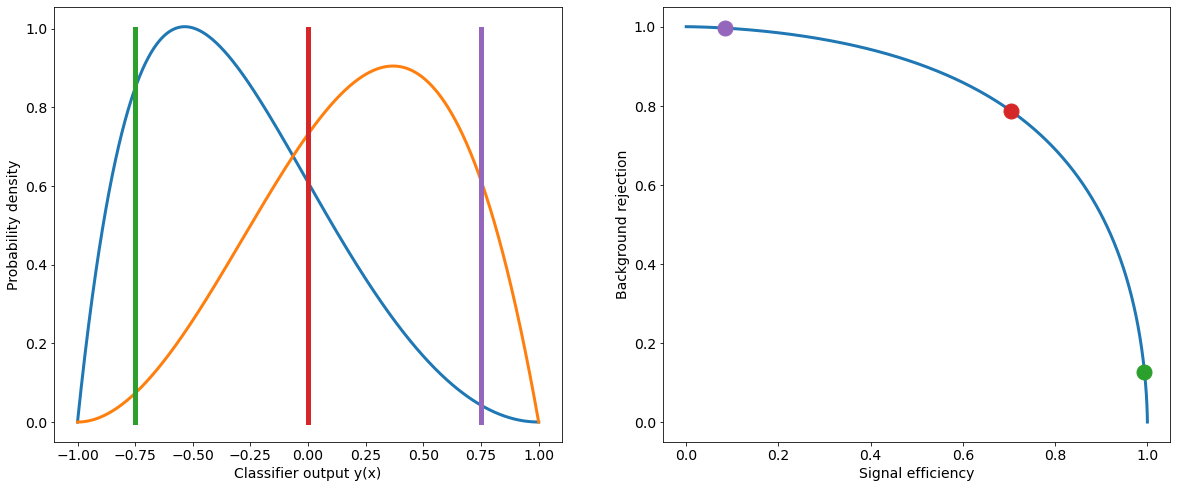

In [4]:
# classifier output value range
xmin = -1.
xmax = 1.

# number of points to consider
npoints = 1000
binw = (xmax-xmin)/npoints

# the x-axis points to draw things for
xx = np.linspace(xmin, xmax, npoints)

# two imaginary output distributions:
# classifier output for background events
yyB = [1./5.6793*(1-exp(-2*x-2))*(2*x-2)**2 for x in xx]      
# classifier output for signal events
yyS = [1./0.3023*(1-exp(0.25*x-0.25))*(-x-1)**2 for x in xx]  

# calculate cumulative sums as a function of classifier output
cumS = 0.
cumB = 0.
cS = []
cB = []
for b,s in zip(yyB,yyS):
    cumB += b*binw
    cumS += s*binw
    cS.append(1.-cumS)
    cB.append(cumB)

fig,ax = plt.subplots(1,2,figsize=(20,8))

# plot the two classifier output curves for background and signal
ax[0].plot(xx,yyB, linewidth=3)
ax[0].plot(xx,yyS, linewidth=3)
ax[0].set_xlabel('Classifier output y(x)')
ax[0].set_ylabel('Probability density')

# plot the ROC curve
ax[1].plot(cS,cB, linewidth=3)
ax[1].set_xlabel('Signal efficiency')
ax[1].set_ylabel('Background rejection')

# plot 3 example classifier outputs at 1/8, 1/2, and 7/8 of the output value range
points = [int(npoints/8), int(npoints/2), int(7*npoints/8)]
for p,n in zip(points,range(len(points))):
    x = cS[p]
    y = cB[p]
    ax[1].plot(x,y,'o',c='C'+str(n+2),markersize=15)
    xp = xmin+p*binw
    ax[0].plot((xp,xp),(0,1),'-',color='C'+str(n+2), linewidth=5)

### 12.3 Cross-validation

Cross-validation describes a useful approach when the sample size is limited. It refers to a given dataset being split in e.g. ten subsets. If training and validation are carried out on four of the ten subsets each, they can exploit nearly all of the statistical power of the data. The classifier is then applied to the remaining two subsets.

The assignment of the ten subsets to the three samples, training, validation and test, are cycled through, such that (in this example) five classifier trainings have to be carried out. While this comes at some computational expense is has the advantage of making optimal use of the available data without having to sacrifice a subset for training and validation.

The plot below illustrates two scenarios of splitting a dataset into training, validation, and test datasets.

<img src="images/CrossValidation.png" width=60%>

#### Bootstrapping

Before diving into different concrete techniques, it is a good point to introduce a concept that is very powerful and widely used: bootstrapping.

One is often faced with datasets of limited size but the task of creating an ensemble of datasets to be used in the context of hypothesis testing (which includes classification).

Such ensembles can be created via bootstrapping in two different ways depending on the exact context:
- One can randomly draw a subset from the full dataset (i.e. by drawing with replacement) and repeat this multiple times. This generates different subsets; however, they are not completely statistically independent.
- In the context of classification one can randomly assign signal and background labels (or whatever categories apply) to a dataset and repeat this to generate multiple datasets with randomised labels.

Both variants can be used for example to create an ensemble of datasets to establish the distribution of a test statistic for a null hypothesis from.

## Multi-variate classification techniques

In the following a few classification techniques are introduced. In the context of this lecture, this can only happen at a rather superficial level. Anyone interested in this is referred to the vast amount of literature available on this topic, which of course includes the two resources used for this lecture.

- Multi-variate classification techniques
   - Likelihood
   - k-Nearest Neighbour
   - Artificial Neural Networks
   - Boosted Decision Trees

#### Some input data

(150, 4)
[5.1 3.5 1.4 0.2]
(150,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']


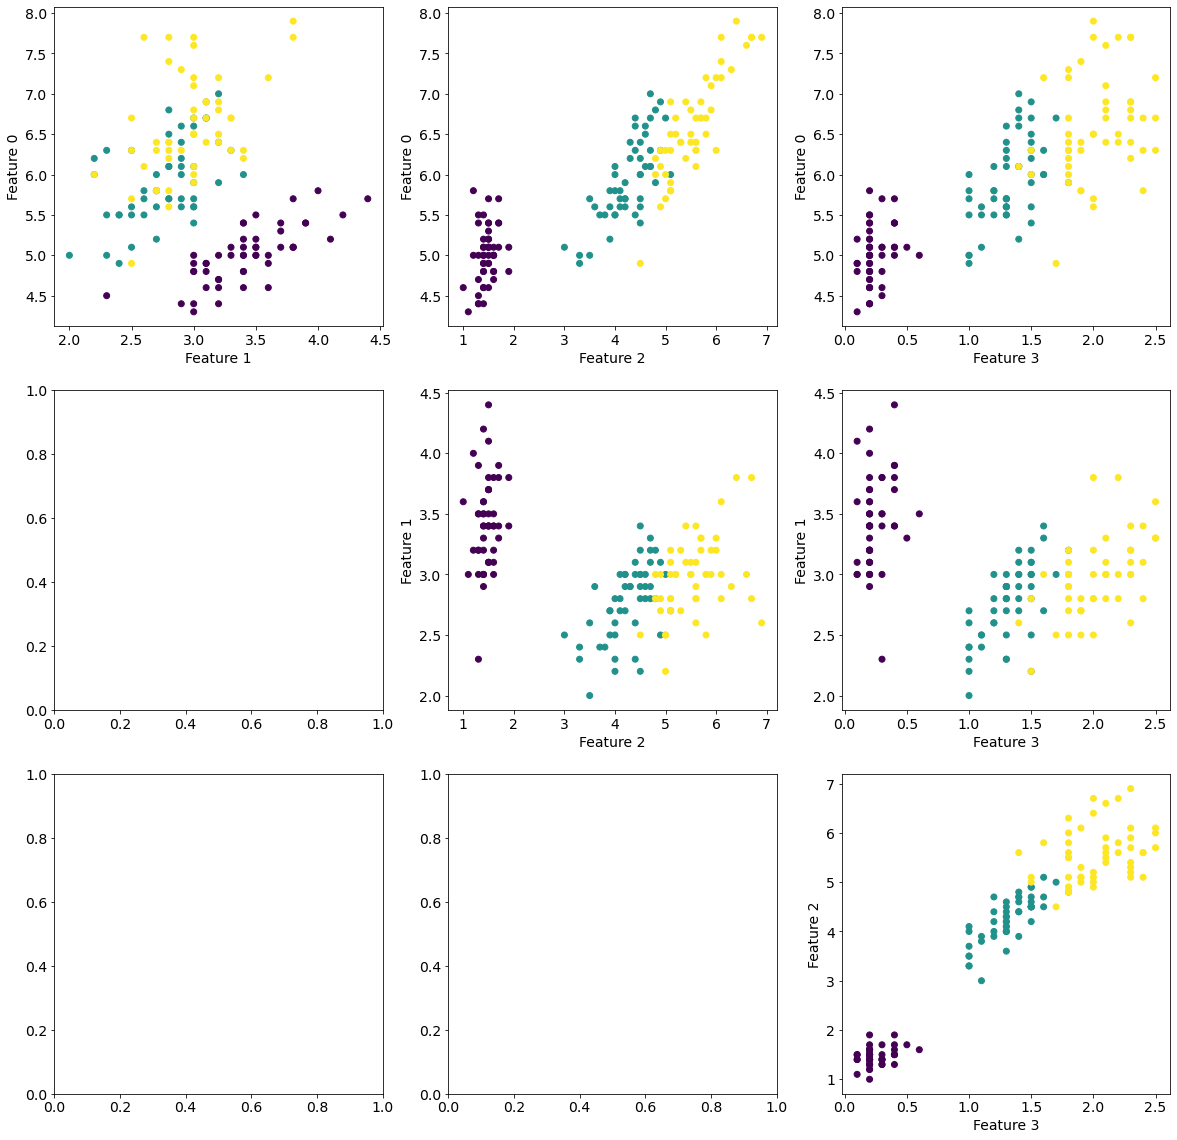

In [5]:
from sklearn.datasets import load_iris
from sklearn import neighbors
iris = load_iris()

print(iris.data.shape)
n_samples, n_features = iris.data.shape
print(iris.data[0])
print(iris.target.shape)
print(iris.target)
print(iris.target_names)

features = []
features.append( [x[0] for x in iris.data] )
features.append( [x[1] for x in iris.data] )
features.append( [x[2] for x in iris.data] )
features.append( [x[3] for x in iris.data] )
fig,ax = plt.subplots(3,3,figsize=(20,20))
for i in range(3):
    for j in range(i,3):
        ax[i][j].scatter(features[j+1],features[i],marker='o',c=iris.target)
        ax[i][j].set_xlabel('Feature {}'.format(j+1))
        ax[i][j].set_ylabel('Feature {}'.format(i))
plt.show()

## k-Nearest Neighbour Classifier

The power of multi-variate classifiers is that they can pick out features that are not obvious by looking at individual observables. This is where the "curse of dimensionality" enters as a small fraction of input phase space represents a large fraction of each variable. As an example, considering a ten-dimensional hypercube of size $1^{10}$, a sub-region that covers as much as half the length in each dimension covers about $0.1\%$ of the total volume.

The k-Nearest Neighbour (kNN) approach addresses this by counting the number of items of the same class (signal or background) in a hyper-sphere around the event in question. By counting up to a total of $k$ nearest neighbours, the method automatically scales the size of the volume that is investigated with the density of entries.

The local densities can then be approximated by the number of signal and background items found among the k nearest neighbours as

$$\frac{p({\bf x}|S)}{p({\bf x}|B)}\propto \frac{P(S|{\bf x})}{P(B|{\bf x})}\approx \frac{k_s({\bf x})}{k_b({\bf x})}.$$

Taking the numbers of signal and background events in the training sample, one can define the probability of a test event at the phase-space point ${\bf x}$ being of signal type:

$$P_s({\bf x})=\frac{k_s({\bf x})}{k_s({\bf x})+k_b({\bf x})}=\frac{k_s({\bf x})}{k({\bf x})}.$$

The example below shows four-dimensional data analysed by a kNN classifier. It shows all possible 2D projections and the classifier output for a range of values of $k$.

In [6]:
# This is an example of getting a prediction off a classifier

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(iris.data,iris.target)
print(iris.target_names[knn.predict([[3, 5, 4, 2]])])

['virginica']


Text(7, 4.2, '$k=30$')

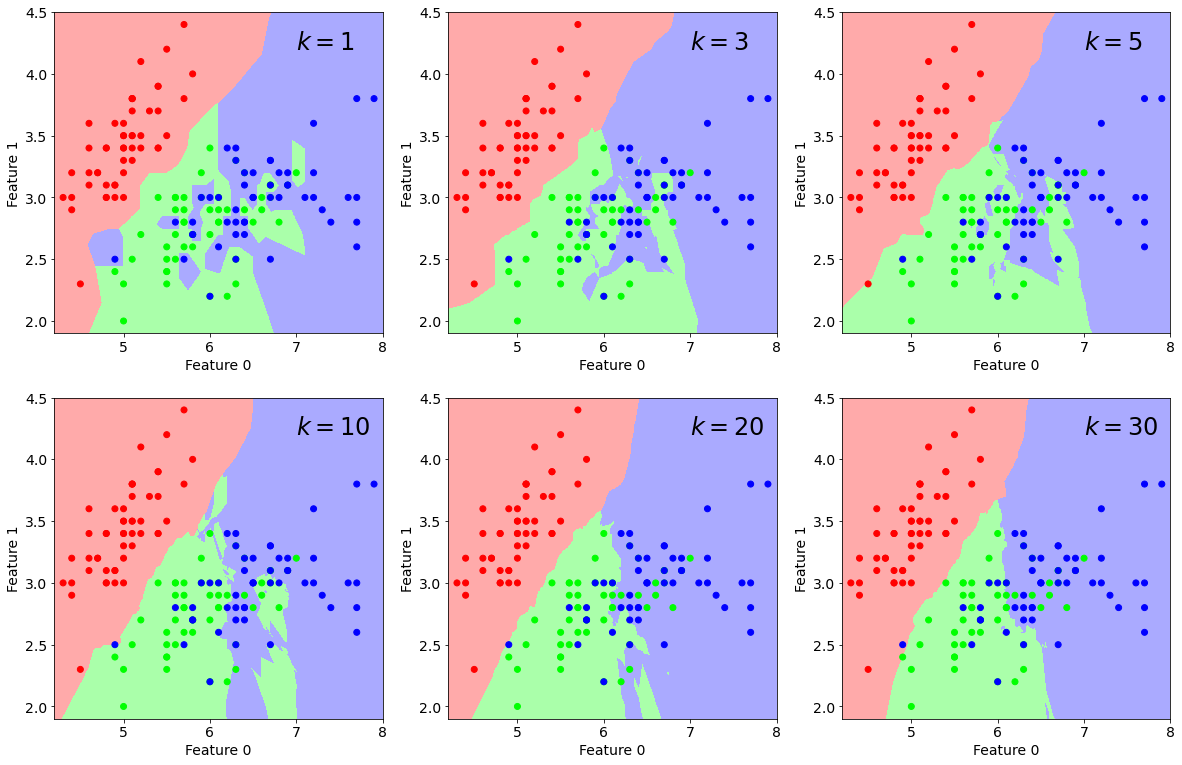

In [7]:
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

#iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                    # avoid this ugly slicing by using a two-dim dataset
y = iris.target

fig,ax = plt.subplots(2,3,figsize=(20,13))

x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                        np.linspace(y_min, y_max, 1000))


knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[0][0].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[0][0].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[0][0].set_xlabel('Feature 0')
ax[0][0].set_ylabel('Feature 1')
ax[0][0].text(7, 4.2, r'$k=1$', fontsize=24)

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[0][1].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[0][1].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[0][1].set_xlabel('Feature 0')
ax[0][1].set_ylabel('Feature 1')
ax[0][1].text(7, 4.2, r'$k=3$', fontsize=24)

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[0][2].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[0][2].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[0][2].set_xlabel('Feature 0')
ax[0][2].set_ylabel('Feature 1')
ax[0][2].text(7, 4.2, r'$k=5$', fontsize=24)

knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[1][0].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[1][0].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[1][0].set_xlabel('Feature 0')
ax[1][0].set_ylabel('Feature 1')
ax[1][0].text(7, 4.2, r'$k=10$', fontsize=24)

knn = neighbors.KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[1][1].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[1][1].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[1][1].set_xlabel('Feature 0')
ax[1][1].set_ylabel('Feature 1')
ax[1][1].text(7, 4.2, r'$k=20$', fontsize=24)

knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(X, y)
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[1][2].pcolormesh(xx, yy, Z, cmap=cmap_light)
ax[1][2].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
ax[1][2].set_xlabel('Feature 0')
ax[1][2].set_ylabel('Feature 1')
ax[1][2].text(7, 4.2, r'$k=30$', fontsize=24)

### Comments

We can see that taking into account more and more neighbours leads to smoother contours of the classification boundaries. The $k=1$ case almost certainly represents a severe case of overtraining as it picks out almost all of the features of the training sample.

For a full interpretation of the quality of the training, we would require a validation sample. Note that the plots above represent a 2D view of a 4D parameter space.

## Artificial Neural Networks

Artificial neural networks use the combination of an arbitrary number of functions to pick out features in the dataset. They are based on a linear mapping

$$y({\bf x})=w_0+\sum_{m=1}^M w_m \cdot h_m({\bf x}),$$

with weights $w_i$ and basis functions $h_m({\bf x})$.

It is more efficient to use a single function $h(t)$ for which functions like sigmoid, $h(t)=1/(1+e^{-t})$, turn out to be most useful as they are approximately linear for some variable range and constant otherwise. This means they select or "activate" a part of the variable range and are therefore called activation function.

In order to retain flexibility when using a single function, the variables undergo a linear transformation resulting in

$$y({\bf x})=w_0^2+\sum_{m=1}^M\left[w_m^2\cdot h\left( w_{0m}^1 + \sum_{k=1}^D w_{km}^1 x_k \right) \right].$$

The following plot shows the schematic layout of such a network with $D=4$ input variables and $M=5$ activation functions.

<img src="images/ANN.png" width=80%>

Several different structures of neural networks exist with increasingly complex structures, e.g. with more than one hidden layer.

## (Boosted) Decision Trees

Decision trees are based on a tree-like structure in which a decision is taken based on one variable and each of the outcomes then leads on to a decision being taken for the next variable, where the second level depends on the outcome of the first.

As a single decision tree offers limited flexibility, there are a number of concepts that increase complexity. One very widely used technique is boosting. This uses the output of several decision trees and computes a linear combination thereof to achieve a classifier output

$$y({\bf x};\alpha_0,\ldots,\alpha_M,{\bf a_0,\dots,a_M})=\sum_{m=0}^M \alpha_m b({\bf x; a_m}),$$

where ${\bf a_m}$ are the parameters of the individual trees and $\alpha_m$ are the boosting weights. There are different algorithms to optimise the boosting and train these classifiers.

<img src="images/random_forest.png" width=80%>
(Source: [Towards Digital Staining using Imaging Mass Spectrometry and Random Forests-Technical Report](https://www.researchgate.net/publication/228540194_Towards_Digital_Staining_using_Imaging_Mass_Spectrometry_and_Random_Forests-Technical_Report), Michael Hanselmann et al., 2009)

Automatically created module for IPython interactive environment


/Users/bretonr/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bretonr/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bretonr/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


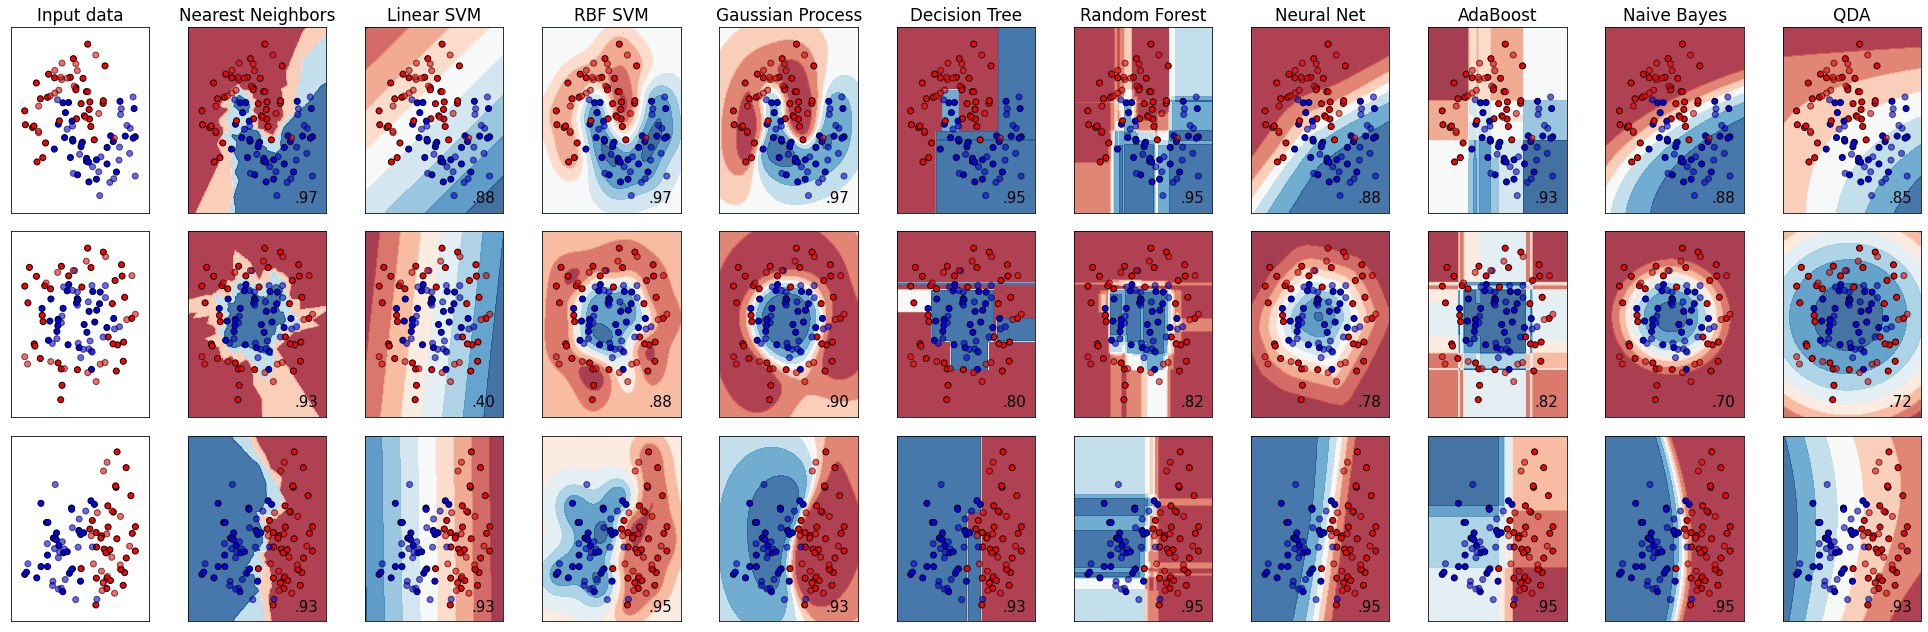

In [8]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>